In [29]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import sys
sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

import tiff_file
import ddm_clean 

import io 
import sys
import csv
import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data

In [3]:
def last_3chars(x):
    return((x.split('\\')[-1])[-7:-4])

In [4]:
###################################################################################
# Specify where the data is and file name for image (or image sequence)           #
###################################################################################

directory = "Z"
exp = "9-5-22_s1_theBigOne"
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\" 
data_dir2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\reordered tiffs\\" #bottom_row_t01\\
plot_saveto= directory+":\\Gregor L\\__Kai Colloids\\SIA\\Data\\"+exp+"\\"

files = glob.glob(data_dir+"*_t*")
#files = sorted(files, key = last_3chars)
print("found %i files" % len(files))
print(int((len(files))/3))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))


found 36 files
12
 0 	 row1_t01.tif
 1 	 row1_t02.tif
 2 	 row1_t03.tif
 3 	 row1_t04.tif
 4 	 row1_t05.tif
 5 	 row1_t06.tif
 6 	 row1_t07.tif
 7 	 row1_t08.tif
 8 	 row1_t09.tif
 9 	 row1_t10.tif
 10 	 row1_t11.tif
 11 	 row1_t12.tif
 12 	 row2_t01.tif
 13 	 row2_t02.tif
 14 	 row2_t03.tif
 15 	 row2_t04.tif
 16 	 row2_t05.tif
 17 	 row2_t06.tif
 18 	 row2_t07.tif
 19 	 row2_t08.tif
 20 	 row2_t09.tif
 21 	 row2_t10.tif
 22 	 row2_t11.tif
 23 	 row2_t12.tif
 24 	 row3_t01.tif
 25 	 row3_t02.tif
 26 	 row3_t03.tif
 27 	 row3_t04.tif
 28 	 row3_t05.tif
 29 	 row3_t06.tif
 30 	 row3_t07.tif
 31 	 row3_t08.tif
 32 	 row3_t09.tif
 33 	 row3_t10.tif
 34 	 row3_t11.tif
 35 	 row3_t12.tif


In [5]:
###### # specify each condition (frame_names) and the time points of data collection (time_array) #
############################################################################################
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
#["1-3 kA-KaiC", "WT KaiC (-kA)", "2-1 kA-KaiC", "AE KaiC (-kA)"]
#["EE KaiC (-kA)", "EA KaiC (-kA)", "WT KaiC (-kA)", "AE KaiC (-kA)"]
#["50% bKaiB", "35% bKaiB", "20% bKaiB", "AE (20% bKaiB)"]
#["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
time_array = [0.67, 3.67, 6.67, 10, 12.83, 17.67, 21.67, 24.92, 28.17, 45.67, 49.08, 69.25]  
#[0.42, 4.75, 8.75, 12.75, 19.92, 22.92, 25.42]
#[3.88, 21.17, 68]
#[0.55, 3.32, 42.73]
#[0.5, 4.5, 8, 12, 20, 24]
#[0.5, 3.5, 6.5, 9.3, 12.1, 15, 18, 21, 24.5, 27.3, 40.5, 44.3]  
#s1 [0.5, 3.2, 17.75, 20, 22, 24.25, 26, 41.75, 44]
#s2 [0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]
#s1 [0.67, 3.67, 6.67, 10, 12.83, 17.67, 21.67, 24.92, 28.17, 45.67, 49.08, 69.25]
#s2 [1, 3.83, 6.83, 10.17, 13.08, 18, 21.92, 25.25, 28.67, 45.92, 49.33, 69.42]
fig_size = 10,10/1.618
font_size = 16
dpi_num = 800
pixel_size = 0.364 # 4*0.091 = 0.364

print((files[0]))
eg_im= tiff_file.imread(files[0])
print(eg_im.shape)
frames_per_tiff = int(eg_im.shape[0])
print(frames_per_tiff)
arr_length = int((len(files))/3)
print(arr_length)

Z:\Gregor L\__Kai Colloids\9-5-22_s1_theBigOne\all tiff files\row1_t01.tif


C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


(5, 1440, 1920)
5
12


In [ ]:
frame_key = 1
condition = frame_names[frame_key]
print(condition)

fig = plt.figure(figsize=(10,10))    #figsize=(10,10)
for i in range (arr_length):
    ax = plt.subplot(3,4,i+1) ##change according to number of frames (6 --> 3,3; 12 --> 4,4)
    ax.set_title("~" + str(time_array[i]) + " hrs", fontsize=10)
    test_image = tiff_file.imread(files[i],key=[frame_key])
    
    filtered_image = filtimage(test_image, filtersize=600)
    fully_processed_image = downscale_local_mean(filtered_image, (2,2), cval=1)
    #ax.matshow(fully_processed_image, cmap = 'gray')
    ax.matshow(test_image, cmap = 'gray')
    plt.axis('off')
    plt.tight_layout(pad=.2)
fig.savefig(data_dir2+"SIA raw images for "+condition+".jpg", dpi=dpi_num)

In [ ]:
frame_key = 3
condition = frame_names[frame_key]
print(condition)

fig = plt.figure(figsize=(10,10))    #figsize=(10,10)
for i in range (arr_length):
    ax = plt.subplot(3,4,i+1) ##change according to number of frames (6 --> 3,3; 12 --> 4,4)
    ax.set_title("~" + str(time_array[i]) + " hrs", fontsize=10)
    test_image = tiff_file.imread(files[i],key=[frame_key])
    
    filtered_image = filtimage(test_image, filtersize=600)
    fully_processed_image = downscale_local_mean(filtered_image, (2,2), cval=1)
    ax.matshow(fully_processed_image, cmap = 'gray')
    #ax.matshow(test_image, cmap = 'gray')
    plt.axis('off')
    plt.tight_layout(pad=.2)
fig.savefig(data_dir2+"SIA proccessed images for row1 "+condition+".jpg", dpi=dpi_num)

In [66]:
def filtimage(image, filtersize=80):
    image = image*1.0 - uf(image,filtersize)
    return image

def show_raw_images(row, ax, i, frame_key):
    if row == 1:
        index_add = 0
    if row == 2:
        index_add = arr_length
    if row == 3:
        index_add = arr_length * 2
    test_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    #print(files[i+index_add])
    ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", f=none)", fontsize=10)
    ax.imshow(test_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)

def show_filtered_images(fsize, row, ax, i, frame_key):
    if row == 1:
        index_add = 0
    if row == 2:
        index_add = arr_length
    if row == 3:
        index_add = arr_length * 2
    test_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    #print(files[i+index_add])
    ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", f="+str(fsize)+")", fontsize=10)
    filtered_image = filtimage(test_image, filtersize= fsize)
    fully_processed_image = downscale_local_mean(filtered_image, (2,2), cval=1)
    ax.imshow(fully_processed_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)

condition: 1-3 kA-WT


<IPython.core.display.Javascript object>


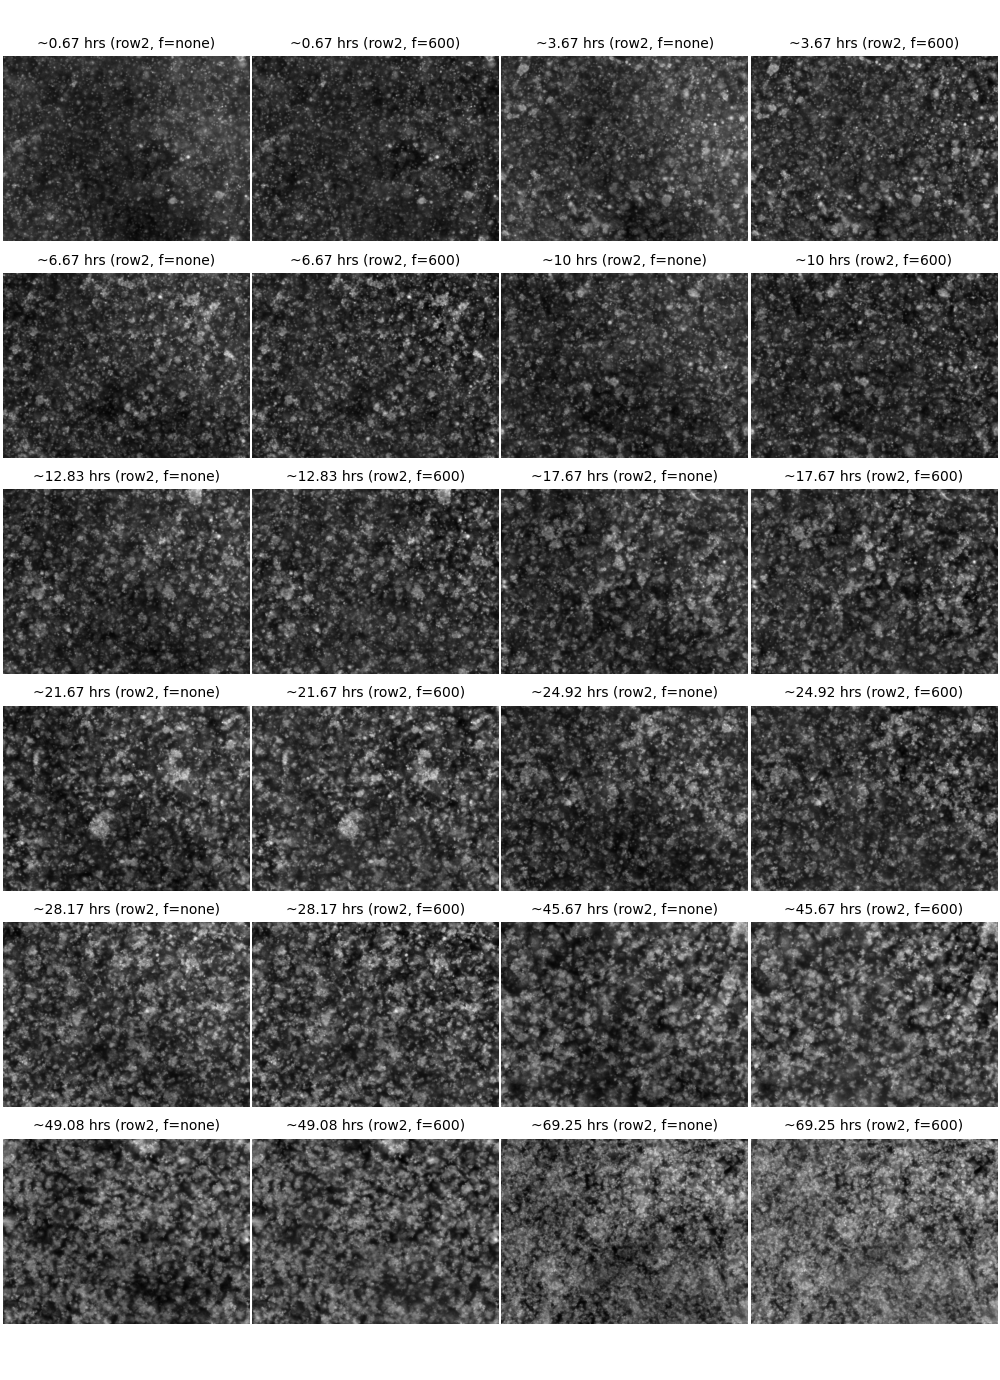

In [68]:
frame_key = 0
condition = frame_names[frame_key]
print("condition: "+condition)
i = 0
    
fsize = 600
row = 2
    
num_rows = int((len(files)/4)/3) *2
fig_height = num_rows*2.3
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if j % 2 == 0:
        show_raw_images(row, ax, i, frame_key)
    else:
        show_filtered_images(fsize, row, ax, i, frame_key)
        i = i + 1 
plt.show()
#fig.savefig(data_dir2+"raw vs filtered images for "+condition+" (row"+str(row)+", f="+str(fsize)+")"+".jpg", dpi=dpi_num)

AE KaiC


<IPython.core.display.Javascript object>


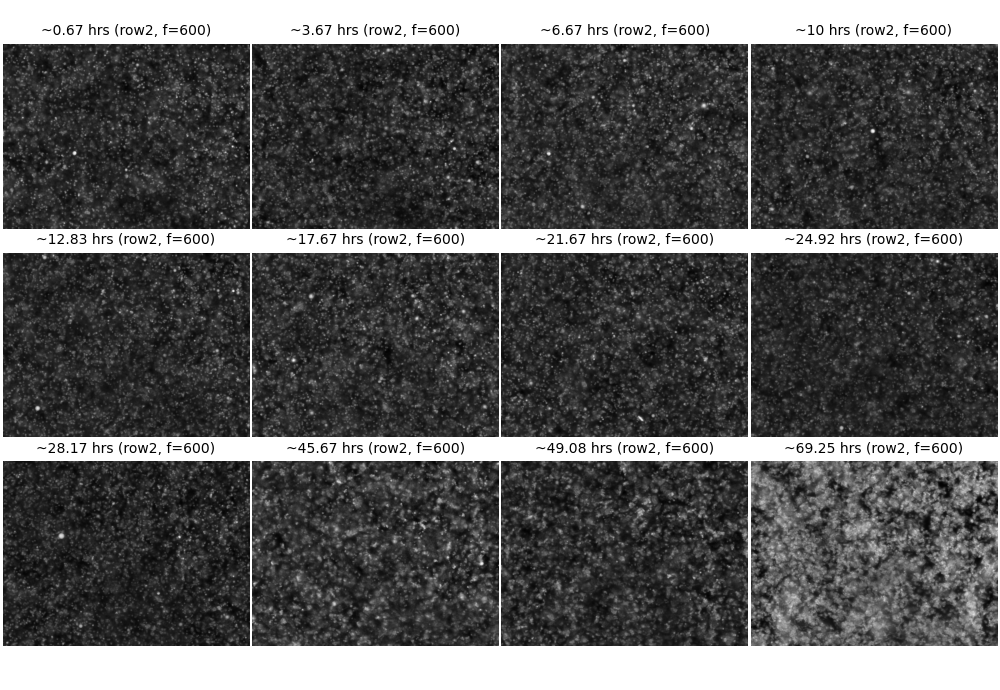

In [36]:
frame_key = 3
condition = frame_names[frame_key]
print(condition)
i = 0
    
fsize = 600
row = 2
    
num_rows = int((len(files)/4)/3)
fig_height = num_rows*2.3
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for ax in axs.flat:
    #print(ax)
    show_filtered_images(fsize, row, ax, i, frame_key)
    i = i + 1 

plt.show()
fig.savefig(data_dir2+"SIA raw images for "+condition+" (row"+str(row)+", f="+str(fsize)+")"+".jpg", dpi=dpi_num)

AE KaiC


<IPython.core.display.Javascript object>


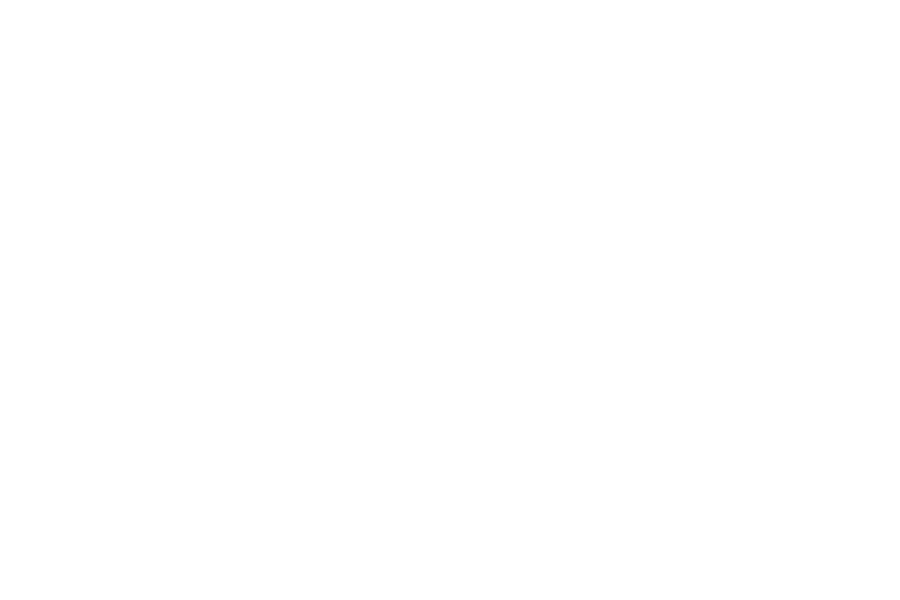

IndexError: list index out of range

In [8]:
frame_key = 3
condition = frame_names[frame_key]
print(condition)
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6), subplot_kw={'xticks': [], 'yticks': []})

    
for ax, time in zip(axs.flat, time_array):
    test_image = tiff_file.imread(files[i],key=[frame_key])
    ax.imshow(test_image, cmap='gray')
    #ax.set_title(str(interp_method))
    ax.set_title("~" + str(time_array[i]) + " hrs", fontsize=10)
plt.tight_layout()
plt.show()

def plot_frame(ax):
    test_image = tiff_file.imread(files[0],key=[0])
    ax.imshow(test_image, cmap='gray')
    ax.set_title("~" + str(time_array[i]) + " hrs", fontsize=10)
    
fig, axs = plt.subplots(3, 7, layout=None)
for ax in axs.flat:
    example_plot(ax)

(5, 1440, 1920)
(5, 1440, 1920)
(5, 1440, 1920)
(5, 1440, 1920)
(5, 1440, 1920)
(5, 1440, 1920)
(5, 1440, 1920)


TypeError: len() takes exactly one argument (0 given)